# **Visualization of Position Encodings**

### Presented By :
1. Sanidhya Gupta (22ucs182)
2. Shreyansh Agarwal (22ucs203)

### Submitted to :
Dr. Preety Singh

### Importing Important Libraries

In [13]:
#!pip install gensium
import gensim.downloader as api             # For downloading Pre-trained Embedding
import matplotlib.pyplot as plt             # Used for plotting figure
import seaborn as sns                       # Used for creating heatmap
import numpy as np                          # For efficiently storing array/matrix and inbuilt array operations
import math                                 # To compute sin() and cos() functions

### Downloading Pre-trained Word Embedding

In [14]:
# Not able to handle Out-Of-Word Vocabulary (OOV) and all words should be in *lower-case*
embedding = api.load('glove-twitter-25')            # 25-dimensional vectors

# ~200MB download (takes more time to load data)
# embedding = api.load('glove-twitter-50')          # 50-dimensional vectors
# >1GB download (takes more time to load data)
# embedding = api.load("word2vec-google-news-300")  # 300-dimensional vectors

### Sample Sentence to show how Word Embedding look

In [15]:
sentence = "yellow apple is better than red apple"
sentence_vectors = [embedding[word] for word in sentence.lower().split() if word in embedding]

# Here we can see both apple have same embeddings (not dependent on the position in sentence)
#print(sentence_vectors[1], sentence_vectors[-1], sep = "\n\n")
print(sentence_vectors)

[array([-0.53491 , -1.3423  ,  0.68075 ,  0.012481, -0.093696,  0.7887  ,
        0.68167 , -0.2631  ,  0.36418 ,  0.10612 ,  0.55277 ,  0.14424 ,
       -3.272   , -0.42571 , -0.67086 , -0.35659 ,  1.0157  , -0.3433  ,
        0.45087 ,  1.3671  , -0.82037 ,  0.49453 ,  1.0454  , -0.16113 ,
       -0.41696 ], dtype=float32), array([ 0.85337  ,  0.011645 , -0.033377 , -0.31981  ,  0.26126  ,
        0.16059  ,  0.010724 , -0.15542  ,  0.75044  ,  0.10688  ,
        1.9249   , -0.45915  , -3.3887   , -1.2152   , -0.054263 ,
       -0.20555  ,  0.54706  ,  0.4371   ,  0.25194  ,  0.0086557,
       -0.56612  , -1.1762   ,  0.010479 , -0.55316  , -0.15816  ],
      dtype=float32), array([-0.12532 , -0.20207 , -0.12672 , -0.57474 , -0.30313 , -0.029884,
        1.1792  , -0.1491  , -0.71315 , -0.12112 ,  0.40652 ,  1.4784  ,
       -5.995   , -0.21617 ,  0.47806 ,  0.43448 ,  0.13489 ,  0.88961 ,
       -0.56926 ,  0.33094 ,  0.13661 ,  0.65844 , -0.41766 ,  0.25164 ,
       -0.055809], dty

### Some Important Functions

In [24]:
# To scale any matrix to range : [-1, 1]
def normalize(matrix, vec_min = None, vec_max = None):      # Using Min-Max Scaling

    if vec_min == None or vec_max == None:
        vec_min = float("inf")
        vec_max = float("-inf")

        # Computing overall minimum and maximum values from the whole matrix
        for vector in matrix:
            vec_min = min(vec_min, vector.min())
            vec_max = max(vec_max, vector.max())

    if vec_min != vec_max:
        res_matrix = []
        for vector in matrix:
            res_matrix.append(2 * (vector - vec_min) / (vec_max - vec_min) - 1)
        return res_matrix
    else:
        # If all elements have same value in the array/vector
        return [np.zeros(len(vector), dtype=np.float32) for _ in range(len(matrix))]



# Compute Position Vectors based on given parameters
# length : number of words/tokens (ie number of positions)
# dim : number of dimension of a vector (default is 25)
# method : gives which type of vector embedding we want to do (like sinusoidal, binary, integer, etc.)
def position_embedding(length, dim = 25, method = "sinusoidal"):
    method = method.lower()
    results = []

    if dim < 0 or length <= 0:
        print("Invalid input(s) passed to position_embedding function")
        return []

    if method == "sinusoidal":

        for pos in range(length):
            new_array = np.zeros(dim, dtype=np.float32)

            for i in range(dim):
                if i % 2 == 0:
                    new_array[i] = math.sin(pos / (10000 ** ((2 * i) / dim)))
                else:
                    new_array[i] = math.cos(pos / (10000 ** ((2 * i) / dim)))

            results.append(new_array)


    elif method == "binary":

        for pos in range(length):
            new_array = np.zeros(dim, dtype=np.float32)

            for i in range(dim):
                new_array[i] = pos & 1
                pos = pos >> 1

            results.append(new_array)

    elif method == "integer":

        for pos in range(length):
            new_array = np.full(dim, pos / length, dtype=np.float32)

            results.append(new_array)

    else:
        print(f"Invalid method \"{method}\" passed to position_embedding function")
        return []

    return results


# Generate Position Encoding after addition of position embedding with word encoding
def encoding(sentence_vectors, pos_method = "sinusoidal"):

    if sentence_vectors == None or len(sentence_vectors) == 0:
        print("Sentence Vector is Empty for encoding function")
        return []

    output_array = []

    if pos_method == "index":

        for i in range(len(sentence_vectors)):
            output_array.append(np.hstack((sentence_vectors[i], [i])))

        return output_array

    elif pos_method == "sinosoidal_append":

        position_vectors = position_embedding(len(sentence_vectors), dim = len(sentence_vectors[0]))

        sentence_vectors = normalize(sentence_vectors, -5, 5)

        for i in range(len(sentence_vectors)):
            output_array.append(np.hstack((sentence_vectors[i], position_vectors[i])))

        return output_array

    position_vectors = position_embedding(len(sentence_vectors), dim = len(sentence_vectors[0]), method = pos_method)

    if len(position_vectors) != len(sentence_vectors):
        print("Position Vector Method is not available, try using any other method")
        return []

    for i in range(len(sentence_vectors)):
        new_array = np.zeros(len(sentence_vectors[0]), dtype=np.float32)

        if pos_method == "binary" or pos_method == "sinusoidal":
            sentence_vectors = normalize(sentence_vectors, -5, 5)

        for j in range(len(sentence_vectors[i])):
            new_array[j] = sentence_vectors[i][j] + position_vectors[i][j]

        output_array.append(new_array)

    return normalize(output_array, -2, 2)


# Used to show heatmap of the matrix
def show_heatmap(matrix, cmap = "GnBu"):

    # x-axis is for dimensions
    # y-axis for positions

    if not matrix or len(matrix) == 0:
        return

    plt.figure(figsize = (len(matrix[0])/4, len(matrix)/4))
    sns.heatmap(matrix, cmap = cmap)
    plt.show()


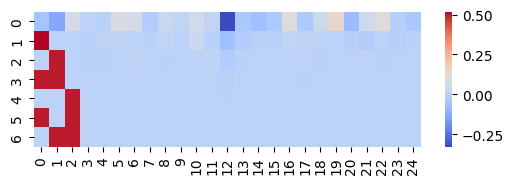

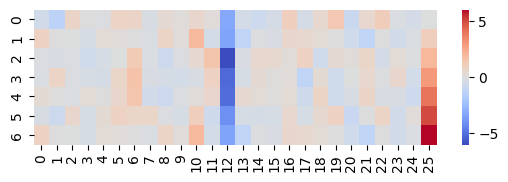

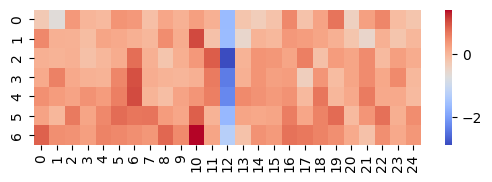

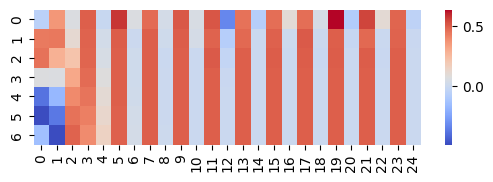

In [25]:
sentence = "yellow apple is better than red apple"
sentence_vectors = [embedding[word] for word in sentence.lower().split() if word in embedding]

show_heatmap(encoding(sentence_vectors, "binary"), 'coolwarm')
show_heatmap(encoding(sentence_vectors, "index"), 'coolwarm')
show_heatmap(encoding(sentence_vectors, "integer"), 'coolwarm')
show_heatmap(encoding(sentence_vectors), 'coolwarm')

### Visualizing Sinusoidal Postion Vectors

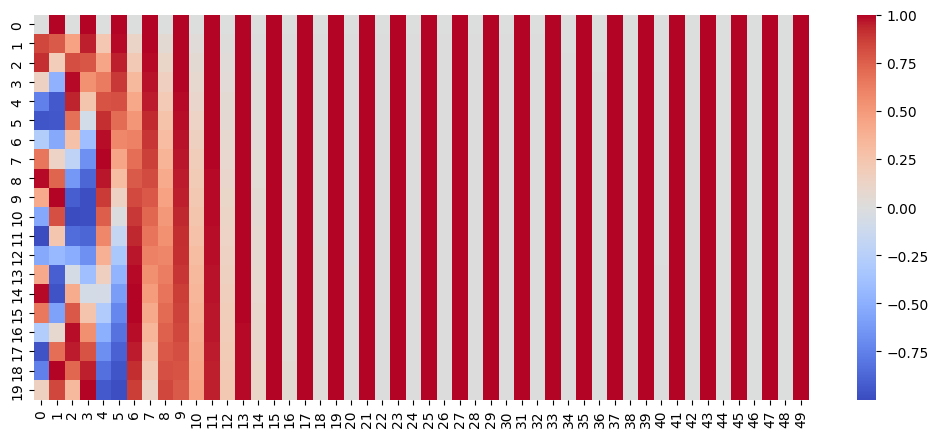

In [18]:
#show_heatmap(position_embedding(100, 50))
show_heatmap(position_embedding(20, 50), 'coolwarm')
#show_heatmap(position_embedding(100, 50), 'RdBu_r')
#show_heatmap(position_embedding(100, 50), 'bwr')
#position_embedding(100, 50)

### Creating Position Encoding based on Input Sentence

In [19]:
def generate_position_encoding(sentence):

    # Step-1 : Generate word encoding using the sentence given as input
    sentence_vectors = [embedding[word] for word in sentence.lower().split() if word in embedding]

    sentence_vectors = normalize(sentence_vectors, -5, 5)

    show_heatmap(sentence_vectors, 'coolwarm')



    # Step-2 : Generate Position Vectors
    position_vectors = position_embedding(len(sentence_vectors), len(sentence_vectors[0]))

    show_heatmap(position_vectors, 'coolwarm')



    # Step-3 : Addition of Word Encoding and Position Vectors
    final_output = []

    for i in range(len(sentence_vectors)):
        new_array = np.zeros(len(sentence_vectors[0]), dtype=np.float32)

        for j in range(len(sentence_vectors[i])):
            new_array[j] = sentence_vectors[i][j] + position_vectors[i][j]

        final_output.append(new_array)

    final_output = normalize(final_output, -2, 2)

    show_heatmap(final_output, 'coolwarm')

    return final_output


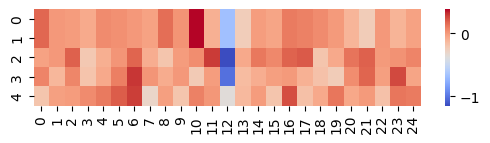

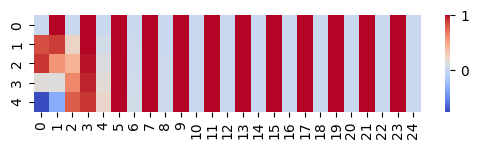

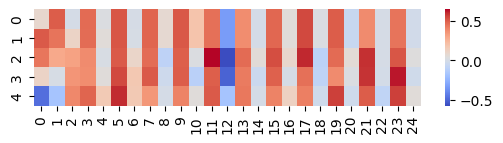

In [20]:
output = generate_position_encoding("Apple Apple was so tasty")
#print(output)

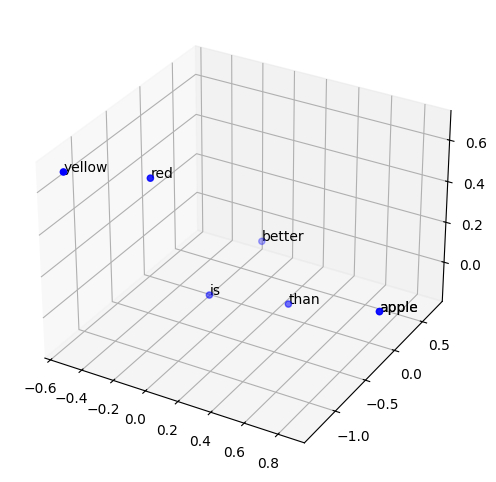

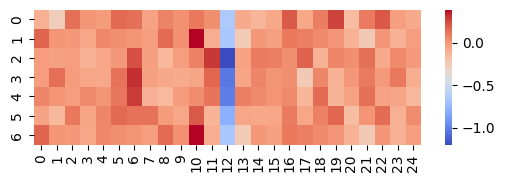

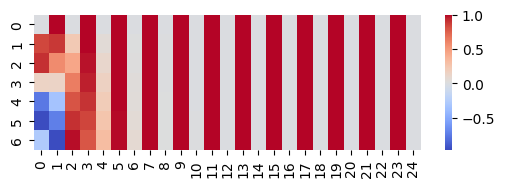

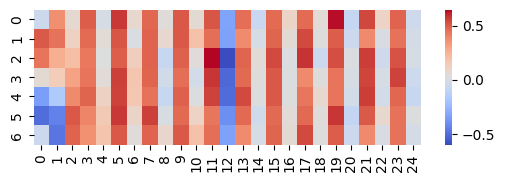

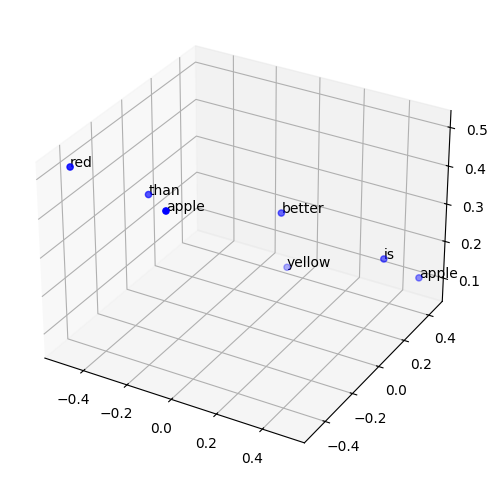

In [21]:
# Some part of the Code below is generated using ChatGPT
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

def plot_graph(sentence, output):

    vectors = np.array(output)

    x = vectors[:, 0]
    y = vectors[:, 1]
    z = vectors[:, 2]

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='blue', marker='o')

    for i, word in enumerate(sentence.lower().split()):
        if word in embedding:
            ax.text(x[i], y[i], z[i], word, size=10, zorder=1, color='k')

    plt.show()


sentence = "yellow apple is better than red apple"
plot_graph(sentence, [embedding[word] for word in sentence.lower().split() if word in embedding])
plot_graph(sentence, generate_position_encoding(sentence))


# **References**

1. Idea of heatmap : https://github.com/gucci-j/pe-visualization
2. Visualization of Position Vector on Sin/Cos Graph : https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers
3. Types of Position Encoding : https://huggingface.co/blog/designing-positional-encoding
4. https://www.youtube.com/watch?v=GeoQBNNqIbM

### Note

Some part of this code is generated using ChatGPT and Gemini.